# Loading Library

In [2]:
# pandas
import pandas as pd

# numpy
import numpy as np

# defaultcit
from collections import defaultdict

# plot with folium
import folium
from IPython.core.display import HTML

# parsing time
from datetime import datetime, timedelta

# plotting with matplotlib
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# plotting with pylab
import pylab as P

# Clustering
from sklearn.cluster import MiniBatchKMeans, KMeans
import time
import json

# change prediction categories into labels
import sklearn
from sklearn import preprocessing
from sklearn import cross_validation 
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

import seaborn as sns
import re

from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss

## Loading Training/Testing Data

** subset to only the fields we need and used in submission (Dates, DayOfWeek, PdDistrict, Address, X, Y, Category) **

In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
# train_df = train_df.sample(n = 10000, random_state = 666)

In [4]:
train_df = pd.DataFrame(train_df)
test_df = pd.DataFrame(test_df)
# train_df = train_df.reset_index(drop=True)
train_df = train_df[['Dates','DayOfWeek','PdDistrict','Address','X','Y','Category']]
train_df.head()

,Dates,DayOfWeek,PdDistrict,Address,X,Y,Category
0,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,WARRANTS
1,2015-05-13 23:53:00,Wednesday,NORTHERN,OAK ST / LAGUNA ST,-122.425892,37.774599,OTHER OFFENSES
2,2015-05-13 23:33:00,Wednesday,NORTHERN,VANNESS AV / GREENWICH ST,-122.424363,37.800414,OTHER OFFENSES
3,2015-05-13 23:30:00,Wednesday,NORTHERN,1500 Block of LOMBARD ST,-122.426995,37.800873,LARCENY/THEFT
4,2015-05-13 23:30:00,Wednesday,PARK,100 Block of BRODERICK ST,-122.438738,37.771541,LARCENY/THEFT


In [5]:
test_df.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [6]:
#Look at the shape
print(train_df.shape)
print(test_df.shape)

(878049, 7)
(884262, 7)


## Feature Creation

** create feature for training data and also for test data **

** difference btw train/test is that training has category data **

In [7]:
def createFeature(train_df):
    #Getting Month of Year, Day of Month, Hour of Day, and Minute of Hour
    month_of_year = []
    day_of_month =[]
    hour_of_day =[]
    min_of_hour =[]
    for i in range(len(train_df.Dates.values)):
        moy = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").month
        dom = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").day
        hod = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").hour
        moh = datetime.strptime(train_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").minute
        month_of_year.append(moy)
        day_of_month.append(dom)
        hour_of_day.append(hod)
        min_of_hour.append(moh)
    train_df['month_of_year'] = month_of_year #Month of the Year feature added
    train_df['day_of_month'] = day_of_month # Day of Month feature added
    train_df['hour_of_day'] = hour_of_day # Hour of Day feature added
    train_df['min_of_hour'] = min_of_hour # Minute of Hour Feature added
    
    #Creating Weeekday/Weekended Feature
    train_df['WeekdayWeeekend'] = train_df['DayOfWeek'].map( {'Monday': 'Weekday', 'Tuesday': 'Weekday', \
                                                          'Wednesday': 'Weekday', 'Thursday': 'Weekday', 'Friday': 'Weekend',\
                                                         'Saturday': 'Weekend', 'Sunday': 'Weekday'} ).astype(object)
    # Creating Midnight/Morning/Afternoon/Night Column
    train_df['TimeOfDay'] = train_df['hour_of_day'].map({0: 'Midnight', 1: 'Midnight', 2:'Midnight', 3:'Midnight', 4:'Morning', \
                                                     5:'Morning', 6:'Morning', 7:'Morning', 8:'Morning', 9:'Morning', \
                                                     10:'Morning', 11:'Morning', 12:'Afternoon', 13:'Afternoon', 14:'Afternoon', \
                                                     15:'Afternoon', 16:'Afternoon', 17:'Afternoon', 18:'Night', 19:'Night', \
                                                     20:'Night', 21:'Night', 22:'Midnight', 23:'Midnight'}).astype(object)
    # Creating Season Feature
    train_df['Season'] = train_df['month_of_year'].map({1: 'Winter', 2: 'Winter', 3:'Spring', 4:'Spring', 5:'Spring', \
                                                     6:'Spring', 7:'Summer', 8:'Summer', 9:'Summer', 10:'Autumn', \
                                                     11:'Autumn', 12:'Winter'}).astype(object)

    
    train_df['District_Type'] = train_df['PdDistrict'].map({'PARK': 'Other', 'CENTRAL': 'Other', 'MISSION': 'Corner', 'NORTHERN': 'Corner', 
                                                              'TENDERLOIN': 'Other', 'INGLESIDE': 'Street', 'TARAVAL': 'Street', 
                                                              'SOUTHERN': 'Other', 'BAYVIEW': 'Other', 'RICHMOND': 'Other'}).astype(object)

        
    #Deleting features not needed
#     train_df = train_df.drop('Descript', 1)
#     train_df = train_df.drop('Resolution', 1)
    train_df = train_df.drop('Address', 1)
    
    #Creating Dummy Variables
    WeekdayWeekend_dummies = pd.get_dummies(train_df.WeekdayWeeekend)
    TimeOfDay_dummies = pd.get_dummies(train_df.TimeOfDay)
    season_dummies = pd.get_dummies(train_df.Season)
    district_dummies = pd.get_dummies(train_df.PdDistrict)
    week_dummies = pd.get_dummies(train_df.DayOfWeek)
#     type_dummies = pd.get_dummies(train_df.Crime_Type)
    corner_dummies = pd.get_dummies(train_df.District_Type)
    
    train_df_new = pd.concat([train_df, WeekdayWeekend_dummies, TimeOfDay_dummies, season_dummies, district_dummies, week_dummies, corner_dummies], axis=1, join_axes=[train_df.index])
    print('Sanity Check')
    print(train_df.shape)
    print(WeekdayWeekend_dummies.shape)
    print(TimeOfDay_dummies.shape)
    print(season_dummies.shape)
    print(district_dummies.shape)
    print(week_dummies.shape)
#     print(type_dummies.shape)
    print(corner_dummies.shape)
    print(train_df_new.shape)
    print('Make sure the total adds up to the last number')
    
    le_crime = preprocessing.LabelEncoder()
    crime = le_crime.fit_transform(train_df_new.Category)
    train_df_new['dummy_Category'] = crime

    return train_df_new
#Calling the feature creation function
train_df_new = createFeature(train_df)
train_df_new.head()

Sanity Check
(878049, 14)
(878049, 2)
(878049, 4)
(878049, 4)
(878049, 10)
(878049, 7)
(878049, 3)
(878049, 44)
Make sure the total adds up to the last number


,Dates,DayOfWeek,PdDistrict,X,Y,Category,month_of_year,day_of_month,hour_of_day,min_of_hour,...,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Corner,Other,Street,dummy_Category
0,2015-05-13 23:53:00,Wednesday,NORTHERN,-122.425892,37.774599,WARRANTS,5,13,23,53,...,0,0,0,0,0,1,1,0,0,37
1,2015-05-13 23:53:00,Wednesday,NORTHERN,-122.425892,37.774599,OTHER OFFENSES,5,13,23,53,...,0,0,0,0,0,1,1,0,0,21
2,2015-05-13 23:33:00,Wednesday,NORTHERN,-122.424363,37.800414,OTHER OFFENSES,5,13,23,33,...,0,0,0,0,0,1,1,0,0,21
3,2015-05-13 23:30:00,Wednesday,NORTHERN,-122.426995,37.800873,LARCENY/THEFT,5,13,23,30,...,0,0,0,0,0,1,1,0,0,16
4,2015-05-13 23:30:00,Wednesday,PARK,-122.438738,37.771541,LARCENY/THEFT,5,13,23,30,...,0,0,0,0,0,1,0,1,0,16


** create feature for test data **

*difference is that Cateogry doesn't exist in test data*

In [8]:
def test_createFeature(test_df):
    #Getting Month of Year, Day of Month, Hour of Day, and Minute of Hour
    month_of_year = []
    day_of_month =[]
    hour_of_day =[]
    min_of_hour =[]
    for i in range(len(test_df.Dates.values)):
        moy = datetime.strptime(test_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").month
        dom = datetime.strptime(test_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").day
        hod = datetime.strptime(test_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").hour
        moh = datetime.strptime(test_df.Dates.values[i], "%Y-%m-%d %H:%M:%S").minute
        month_of_year.append(moy)
        day_of_month.append(dom)
        hour_of_day.append(hod)
        min_of_hour.append(moh)
    test_df['month_of_year'] = month_of_year #Month of the Year feature added
    test_df['day_of_month'] = day_of_month # Day of Month feature added
    test_df['hour_of_day'] = hour_of_day # Hour of Day feature added
    test_df['min_of_hour'] = min_of_hour # Minute of Hour Feature added
    
    #Creating Weeekday/Weekended Feature
    test_df['WeekdayWeeekend'] = test_df['DayOfWeek'].map( {'Monday': 'Weekday', 'Tuesday': 'Weekday', \
                                                          'Wednesday': 'Weekend', 'Thursday': 'Weekend', 'Friday': 'Weekend',\
                                                         'Saturday': 'Weekend', 'Sunday': 'Weekday'} ).astype(object)
    # Creating Midnight/Morning/Afternoon/Night Column
    test_df['TimeOfDay'] = test_df['hour_of_day'].map({0: 'Night', 1: 'Midnight', 2:'Midnight', 3:'Midnight', 4:'Midnight', \
                                                     5:'Midnight', 6:'Midnight', 7:'Midnight', 8:'Morning', 9:'Morning', \
                                                     10:'Morning', 11:'Morning', 12:'Afternoon', 13:'Afternoon', 14:'Afternoon', \
                                                     15:'Afternoon', 16:'Afternoon', 17:'Afternoon', 18:'Afternoon', 19:'Afternoon', \
                                                     20:'Night', 21:'Night', 22:'Night', 23:'Night'}).astype(object)
    # Creating Season Feature
    test_df['Season'] = test_df['month_of_year'].map({1: 'Winter', 2: 'Winter', 3:'Spring', 4:'Spring', 5:'Spring', \
                                                     6:'Spring', 7:'Summer', 8:'Summer', 9:'Summer', 10:'Autumn', \
                                                     11:'Autumn', 12:'Winter'}).astype(object)

    
    
    test_df['District_Type'] = test_df['PdDistrict'].map({'PARK': 'Other', 'CENTRAL': 'Other', 'MISSION': 'Corner', 'NORTHERN': 'Corner', 
                                                              'TENDERLOIN': 'Other', 'INGLESIDE': 'Street', 'TARAVAL': 'Street', 
                                                              'SOUTHERN': 'Other', 'BAYVIEW': 'Other', 'RICHMOND': 'Other'}).astype(object)

        
    #Deleting features not needed
#     test_df = test_df.drop('Descript', 1)
#     test_df = test_df.drop('Resolution', 1)
    test_df = test_df.drop('Address', 1)
    
    #Creating Dummy Variables
    WeekdayWeekend_dummies = pd.get_dummies(test_df.WeekdayWeeekend)
    TimeOfDay_dummies = pd.get_dummies(test_df.TimeOfDay)
    season_dummies = pd.get_dummies(test_df.Season)
    district_dummies = pd.get_dummies(test_df.PdDistrict)
    week_dummies = pd.get_dummies(test_df.DayOfWeek)
#     type_dummies = pd.get_dummies(test_df.Crime_Type)
    corner_dummies = pd.get_dummies(test_df.District_Type)
    
    test_df_new = pd.concat([test_df, WeekdayWeekend_dummies, TimeOfDay_dummies, season_dummies, district_dummies, week_dummies, corner_dummies], axis=1, join_axes=[test_df.index])
    print('Sanity Check')
    print(test_df.shape)
    print(WeekdayWeekend_dummies.shape)
    print(TimeOfDay_dummies.shape)
    print(season_dummies.shape)
    print(district_dummies.shape)
    print(week_dummies.shape)
#     print(type_dummies.shape)
    print(corner_dummies.shape)
    print(test_df_new.shape)
    print('Make sure the total adds up to the last number')
    
#     le_crime = preprocessing.LabelEncoder()
#     crime = le_crime.fit_transform(train_df_new.Category)
#     train_df_new['dummy_Category'] = crime

    return test_df_new
#Calling the feature creation function

test_df_new = test_createFeature(test_df)
test_df_new.head()

Sanity Check
(884262, 14)
(884262, 2)
(884262, 4)
(884262, 4)
(884262, 10)
(884262, 7)
(884262, 3)
(884262, 44)
Make sure the total adds up to the last number


,Id,Dates,DayOfWeek,PdDistrict,X,Y,month_of_year,day_of_month,hour_of_day,min_of_hour,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Corner,Other,Street
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,-122.399588,37.735051,5,10,23,59,...,0,0,0,1,0,0,0,0,1,0
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,-122.391523,37.732432,5,10,23,51,...,0,0,0,1,0,0,0,0,1,0
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,-122.426002,37.792212,5,10,23,50,...,0,0,0,1,0,0,0,1,0,0
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,-122.437394,37.721412,5,10,23,45,...,0,0,0,1,0,0,0,0,0,1
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,-122.437394,37.721412,5,10,23,45,...,0,0,0,1,0,0,0,0,0,1


#Exploring with Street Corner Feature

In [9]:
test_df_new.shape

(884262, 44)

In [10]:
train_df_new.columns

Index(['Dates', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'Category',
       'month_of_year', 'day_of_month', 'hour_of_day', 'min_of_hour',
       'WeekdayWeeekend', 'TimeOfDay', 'Season', 'District_Type', 'Weekday',
       'Weekend', 'Afternoon', 'Midnight', 'Morning', 'Night', 'Autumn',
       'Spring', 'Summer', 'Winter', 'BAYVIEW', 'CENTRAL', 'INGLESIDE',
       'MISSION', 'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL',
       'TENDERLOIN', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday', 'Corner', 'Other', 'Street', 'dummy_Category'],
      dtype='object')

In [11]:
test_df_new.columns

Index(['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'month_of_year',
       'day_of_month', 'hour_of_day', 'min_of_hour', 'WeekdayWeeekend',
       'TimeOfDay', 'Season', 'District_Type', 'Weekday', 'Weekend',
       'Afternoon', 'Midnight', 'Morning', 'Night', 'Autumn', 'Spring',
       'Summer', 'Winter', 'BAYVIEW', 'CENTRAL', 'INGLESIDE', 'MISSION',
       'NORTHERN', 'PARK', 'RICHMOND', 'SOUTHERN', 'TARAVAL', 'TENDERLOIN',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', 'Corner', 'Other', 'Street'],
      dtype='object')

##Prediction

### Feature Inclusion/Exclusion

In [12]:
# # Lat/Long
# X_feature = (False, 'X')
# Y_feature = (False, 'Y')

# # Time
# Month_feature = (False, 'month_of_year')
# Day_feature = (True, 'day_of_month')
# Hour_feature = (True, 'hour_of_day')
# Min_feature = (True, 'min_of_hour')

# # Day of Week
# Friday_feature = (True, 'Friday') 
# Monday_feature = (True, 'Monday')
# Saturday_feature = (True, 'Saturday')
# Sunday_feature = (True, 'Sunday')
# Thursday_feature = (True, 'Thursday')
# Tuesday_feature = (True, 'Tuesday')
# Wednesday_feature = (True, 'Wednesday')

# #Weekday/Weekend
# Weekday_feature = (False, 'Weekday') 
# Weekend_feature = (False, 'Weekend') 

# #Season 
# Autumn_feature = (False, 'Autumn') 
# Spring_feature = (False, 'Spring') 
# Summer_feature = (False, 'Summer') 
# Winter_feature = (False, 'Winter') 

# #Time of Day
# Midnight_feature = (True, 'Midnight') 
# Morning_feature = (True, 'Morning') 
# Afternoon_feature = (True, 'Afternoon') 
# Night_feature = (True, 'Night') 

# # District
# BAYV_feature = (True, 'BAYVIEW')
# CENT_feature = (True, 'CENTRAL')
# INGL_feature = (True, 'INGLESIDE')
# MISS_feature = (True, 'MISSION')
# NORT_feature = (True, 'NORTHERN')
# PARK_feature = (True, 'PARK')
# RICH_feature = (True, 'RICHMOND')
# SOUT_feature = (True, 'SOUTHERN')
# TARA_feature = (True, 'TARAVAL')
# TEND_feature = (True, 'TENDERLOIN')

# # # Crime Type
# # Blue_feature = (False, 'Blue')
# # White_feature = (False, 'White')
# # Other_feature = (False, 'Other')

# # District Type
# Corner_feature = (False, 'Corner')
# Street_feature = (False, 'Street')
# District_Other_feature = (False, 'Other')

# Lat/Long
X_feature = (True, 'X')
Y_feature = (True, 'Y')

# Time
Month_feature = (True, 'month_of_year')
Day_feature = (True, 'day_of_month')
Hour_feature = (True, 'hour_of_day')
Min_feature = (True, 'min_of_hour')

# Day of Week
Friday_feature = (True, 'Friday') 
Monday_feature = (True, 'Monday')
Saturday_feature = (True, 'Saturday')
Sunday_feature = (True, 'Sunday')
Thursday_feature = (True, 'Thursday')
Tuesday_feature = (True, 'Tuesday')
Wednesday_feature = (True, 'Wednesday')

#Weekday/Weekend
Weekday_feature = (True, 'Weekday') 
Weekend_feature = (True, 'Weekend') 

#Season 
Autumn_feature = (True, 'Autumn') 
Spring_feature = (True, 'Spring') 
Summer_feature = (True, 'Summer') 
Winter_feature = (True, 'Winter') 

#Time of Day
Midnight_feature = (True, 'Midnight') 
Morning_feature = (True, 'Morning') 
Afternoon_feature = (True, 'Afternoon') 
Night_feature = (True, 'Night') 

# District
BAYV_feature = (True, 'BAYVIEW')
CENT_feature = (True, 'CENTRAL')
INGL_feature = (True, 'INGLESIDE')
MISS_feature = (True, 'MISSION')
NORT_feature = (True, 'NORTHERN')
PARK_feature = (True, 'PARK')
RICH_feature = (True, 'RICHMOND')
SOUT_feature = (True, 'SOUTHERN')
TARA_feature = (True, 'TARAVAL')
TEND_feature = (True, 'TENDERLOIN')

# # Crime Type
# Blue_feature = (False, 'Blue')
# White_feature = (False, 'White')
# Other_feature = (False, 'Other')

# District Type
Corner_feature = (True, 'Corner')
Street_feature = (True, 'Street')
District_Other_feature = (True, 'Other')

In [13]:
feature_list = [
                X_feature, Y_feature,
                Month_feature, Day_feature, Hour_feature, Min_feature,
                Monday_feature, Tuesday_feature, Wednesday_feature, Thursday_feature, Friday_feature, 
                Saturday_feature, Sunday_feature,
                Weekday_feature, Weekend_feature, 
                Autumn_feature, Spring_feature, Summer_feature, Winter_feature,
                Midnight_feature, Morning_feature, Afternoon_feature, Night_feature, 
                BAYV_feature, CENT_feature, INGL_feature, MISS_feature, NORT_feature, PARK_feature, 
                RICH_feature, SOUT_feature, TARA_feature, TEND_feature,
#                 Blue_feature, White_feature, Other_feature, 
                Corner_feature, Street_feature, District_Other_feature
               ]
features = [str(x[1]) for x in feature_list if x[0]]

# Trainding and Validation

In [14]:
training, validation = train_test_split(train_df_new, train_size=.60)

In [14]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()

# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(training[features].values, training['dummy_Category'].values)
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True  True]
[33 28 31 30 32 34 21 27 19 26  4  3 25  2 29 12 14 13 11 10  8  7  9  6 17
 23 24 16 22 18 15 20  5  1  1  1]


In [15]:
# from sklearn import metrics
# from sklearn.ensemble import ExtraTreesClassifier

# # fit an Extra Trees model to the data
# model = ExtraTreesClassifier()
# model.fit(training[features].values, training['dummy_Category'].values)
# # display the relative importance of each attribute
# print(model.feature_importances_)

In [16]:
# keep_index = list(rfe.support_)
keep_index = list(rfe.ranking_)

In [17]:
keep_features = [features[index] for index, value in enumerate(keep_index) if value < 10]
keep_features

['Friday',
 'Saturday',
 'Weekday',
 'Morning',
 'Afternoon',
 'Night',
 'BAYVIEW',
 'TENDERLOIN',
 'Corner',
 'Street',
 'Other']

In [77]:
keep_features2 = [features[index] for index, value in enumerate(keep_index) if value < 2]
keep_features3 = [features[index] for index, value in enumerate(keep_index) if value < 4]
keep_features4 = [features[index] for index, value in enumerate(keep_index) if value < 6]
keep_features5 = [features[index] for index, value in enumerate(keep_index) if value < 8]
keep_features6 = [features[index] for index, value in enumerate(keep_index) if value < 10]
keep_features7 = [features[index] for index, value in enumerate(keep_index) if value < 12]
keep_features8 = [features[index] for index, value in enumerate(keep_index) if value < 14]
keep_features9 = [features[index] for index, value in enumerate(keep_index) if value < 16]
keep_features10 = [features[index] for index, value in enumerate(keep_index) if value < 18]
keep_features11 = [features[index] for index, value in enumerate(keep_index) if value < 20]

In [18]:
# X, y = training[features].values, training['dummy_Category'].values
# print(X.shape,y.shape)
# print(type(X),type(y))

# X_new = SelectKBest(f_regression, k=2).fit_transform(X, y)
# print(X_new.shape)
# print(pd.DataFrame(X_new))


## Logistic Regression

### Create Pipline 
** doesn't work.... **

In [20]:
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline

In [45]:
training, validation = train_test_split(train_df_new, train_size=.60)

In [46]:
logistic = linear_model.LogisticRegression()

pca = decomposition.PCA(whiten=True)
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

In [47]:
pca.fit_transform(training[features])
print(pca.explained_variance_ratio_)

[  7.15466275e-01   1.60540595e-01   9.07014375e-02   2.48765679e-02
   1.17667812e-03   1.03825915e-03   6.24662867e-04   6.06676192e-04
   5.99178204e-04   4.79488401e-04   4.62991309e-04   3.17398254e-04
   3.13261213e-04   3.07089689e-04   3.00127624e-04   2.99274267e-04
   2.89278258e-04   2.79484728e-04   2.60141645e-04   2.36383463e-04
   2.10155131e-04   2.02856039e-04   1.70579287e-04   1.31684106e-04
   1.09111077e-04   1.96564312e-07   1.69223945e-07   1.41100843e-31
   7.59033970e-33   7.59033970e-33   7.59033970e-33   7.59033970e-33
   7.59033970e-33   7.59033970e-33   7.59033970e-33   7.59033970e-33]


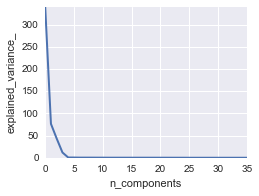

In [48]:
# pca.fit(training[features])
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [57]:
# Prediction

n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Cs = np.logspace(-4, 4, 3)

#Parameters of pipelines can be set using ‘__’ separated parameter names:

estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(training[features], training['dummy_Category'])

/Users/carlo_liquido/anaconda/lib/python3.4/site-packages/sklearn/cross_validation.py:417: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('pca', PCA(copy=True, n_components=None, whiten=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'logistic__C': array([  1.00000e-04,   1.00000e+00,   1.00000e+04]), 'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [58]:
# estimator.score(validation[features], validation['dummy_Category'])
predicted = np.array(estimator.predict_proba(validation[features]))
log_loss(validation['dummy_Category'], predicted) 

3.5617459347413405

### Just use keep features based on skbest

In [76]:
#Logistic Regression for comparison
model = LogisticRegression(C=.1)
model.fit(training[keep_features], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features1]))
log_loss(validation['dummy_Category'], predicted) 

2.6129125616700111

In [79]:
model.fit(training[keep_features2], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features2]))
log_loss(validation['dummy_Category'], predicted) 

2.6655445818679446

In [80]:
model.fit(training[keep_features3], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features3]))
log_loss(validation['dummy_Category'], predicted) 

2.6644519589782734

In [81]:
model.fit(training[keep_features4], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features4]))
log_loss(validation['dummy_Category'], predicted) 

2.6418390424735612

In [82]:
model.fit(training[keep_features5], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features5]))
log_loss(validation['dummy_Category'], predicted) 

2.6251225126883804

In [83]:
model.fit(training[keep_features6], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features6]))
log_loss(validation['dummy_Category'], predicted) 

2.6129125616697424

In [84]:
model.fit(training[keep_features7], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features7]))
log_loss(validation['dummy_Category'], predicted) 

2.6126947082154568

In [85]:
model.fit(training[keep_features8], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features8]))
log_loss(validation['dummy_Category'], predicted) 

2.6125926163405153

In [86]:
model.fit(training[keep_features9], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features9]))
log_loss(validation['dummy_Category'], predicted) 

2.6072294100961075

In [87]:
model.fit(training[keep_features10], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features10]))
log_loss(validation['dummy_Category'], predicted) 

2.5991616767874071

In [88]:
model.fit(training[keep_features11], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[keep_features11]))
log_loss(validation['dummy_Category'], predicted) 

2.5975554374874879

In [21]:
model.fit(training[features], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[features]))
log_loss(validation['dummy_Category'], predicted) 

2.6120055024309714

In [22]:
# from sklearn.externals import joblib
# joblib.dump(model, 'logistic_regression.pkl') 

['logistic_regression.pkl',
 'logistic_regression.pkl_01.npy',
 'logistic_regression.pkl_02.npy',
 'logistic_regression.pkl_03.npy',
 'logistic_regression.pkl_04.npy',
 'logistic_regression.pkl_05.npy']

In [23]:
import pickle
# now you can save it to a file
with open('logistic_regression.pkl', 'wb') as f:
    pickle.dump(model, f)

In [34]:
test_df_testing = test_df_new.iloc[[1,100,1000,10000,100000]]
test_df_testing = test_df_testing[features]
# test_df_testing[:10]
test_df_testing.to_csv('testing_df.csv', index=False)

In [ ]:
param_grid = {'C': [0.150, 0.125, 0.1, .075, .05] }

param_scores = ['precision', 'recall']



Haven't got the gridsearch on logistic regression working yet (possibly need to use less than full data

In [ ]:
# for score in param_scores:
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
#     clf.fit(training[features], training['dummy_Category'])

#     print("Best parameters set found on development set:")
#     print()
#     print(clf.best_params_)
#     print()
#     print("Grid scores on development set:")
#     print()
#     for params, mean_score, scores in clf.grid_scores_:
#         print("%0.3f (+/-%0.03f) for %r" % (mean_score, scores.std() * 2, params))
#     print()
#     print("Detailed classification report:")
#     print()
#     print("The model is trained on the full development set.")
#     print("The scores are computed on the full evaluation set.")
#     print()
#     y_true, y_pred = validation['dummy_Category'], clf.predict(training[features])
#     print(classification_report(y_true, y_pred))
#     print()

## Bernoulli

In [15]:
# training, validation = train_test_split(train_df_new, train_size=.60)
model = BernoulliNB()
model.fit(training[features], training['dummy_Category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [16]:
predicted = np.array(model.predict_proba(validation[features]))

In [17]:
validation['dummy_Category'].shape

(351220,)

In [18]:
log_loss(validation['dummy_Category'], predicted)

2.6120055024309714

** FOR SUBMISSION **

** need to train on full trainig set and use the reformatted test data to make prediction **

In [19]:
test_df_new = test_df_new.ix[:,1:len(test_df_new)]
test_df_new.shape

(884262, 43)

In [20]:
# training, validation = train_test_split(train_df_new, train_size=.60)
model = BernoulliNB()
model.fit(train_df_new[features], train_df_new['dummy_Category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [ ]:
predicted = np.array(model.predict_proba(test_df_new[features]))

In [ ]:
ex_submission = pd.read_csv("kaggle_data/sampleSubmission.csv")

In [ ]:
result=pd.DataFrame(predicted, columns=ex_submission.columns[1:len(ex_submission)])
# result.to_csv('testResult.csv', index = True, index_label = 'Id' )

## KNN

In [ ]:
knn = KNeighborsClassifier(n_neighbors=50, weights='uniform')
knn.fit(training[features], training['dummy_Category']) 
knn_predicted = np.array(knn.predict_proba(validation[features]))
log_loss(validation['dummy_Category'], knn_predicted)

---

# OLD STUFF THAT STILL MAY BE OF USE

# Bernoulli

In [ ]:
Bernoulli_model = BernoulliNB()
Bernoulli_model.fit(x_train, y_train)
# predicted = Bernoulli_model.predict_proba(test_data[features])

In [ ]:
Bernoulli_model.score(x_test, y_test) 

In [ ]:
training, validation = train_test_split(train_df_new, train_size=.60)
model = BernoulliNB()
model.fit(training[features], training['dummy_Category'])
predicted = np.array(model.predict_proba(validation[features]))
log_loss(validation['dummy_Category'], predicted) 

In [ ]:
training, validation = train_test_split(train_df_new, train_size=.60)
model = BernoulliNB()
model.fit(training[features], training['dummy_Category'])
predicted = np.array(model.predict_proba(test_df_new[features]))
log_loss(validation['dummy_Category'], predicted)  

In [ ]:
result=pd.DataFrame(predicted, columns=ex_submission.columns[1:len(ex_submission)])
# result.to_csv('testResult.csv', index = True, index_label = 'Id' )

In [ ]:
len(result)

In [ ]:
model.score(validation[features], validation['dummy_Category']) 

## SVM

**1) svm with single fold**

In [ ]:
print(x_train.shape, x_test.shape)
print(y_train.shape,y_test.shape)

In [ ]:
y_train.head()

In [ ]:
#KNN - gives lowest error; does well with tons of data; ratio does not go to infiniti; data, ratio, (30 max)
# extra features on day: holiday; weekend; weekday; time of year; but do exploratory analyssi to find best features
# randomforest and decision tree will tell you the importance of feature
# 2D kernel density estimation

svc_model = svm.SVC(kernel = 'rbf', C=20, gamma=.0075).fit(x_train, y_train)

svc_model.score(x_test, y_test) 

**2) svm with crossfolds**

In [ ]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

In [ ]:
x_train.columns

In [ ]:
print(train_df_new[features].shape)
print(train_df_new['dummy_Category'].shape)

In [ ]:
svm_2 = svm.SVC(kernel = 'rbf', C=50, gamma=.001)
scores = cross_validation.cross_val_score(
    svm_2, train_df_new[features], train_df_new['dummy_Category'], cv=5)
scores

In [ ]:
SVM_tuned_parameters = [{'kernel': ['rbf'],
                     'gamma': [.0075, .005, .001, .00075], 'C': [20, 30, 40, 50, 60, 70]}
                   ]

SVM_scores = ['precision', 'recall']

In [ ]:
print(SVM_tuned_parameters)
print(SVM_scores)

In [ ]:
for score in SVM_scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm.SVC(C=1), SVM_tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

## KNN

In [ ]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
    train_df_new[features], train_df_new['dummy_Category'], test_size=0.2, random_state=0)

knn = KNeighborsClassifier(n_neighbors=56, weights='uniform')
knn.fit(x_train, y_train) 
knn.score(x_test, y_test) 

# KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
#            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
#            weights='uniform')

# knn.predict(x_test)
# array([1, 2, 1, 0, 0, 0, 2, 1, 2, 0])
# y_test
# array([1, 1, 1, 0, 0, 0, 2, 1, 2, 0])

In [ ]:
KNN_tuned_parameters = [{'n_neighbors': [20, 25, 30, 35, 40, 45]}
                   ]

KNN_scores = ['precision', 'recall']

In [ ]:
print(KNN_tuned_parameters)
print(KNN_scores)

In [ ]:
for score in KNN_scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(knn, KNN_tuned_parameters, cv=5,
                       scoring='%s_weighted' % score)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(x_test)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
n_neighbors, weights=weights